In [1]:
import os 
import sys 
sys.path.append("../training")
import pickle
import copy
import time

import numpy as np
import matplotlib.pyplot as plt 
from sklearn.metrics import accuracy_score, auc, roc_curve

# Local imports
from radius_labeler import RadiusLabeler # Prefer the other one, but just to have more than one labeling schema
from threshold import ThresholdModel

## Load data

In [2]:
NP_SEED = 0
np.random.seed(NP_SEED)

START_WINDOW = 0
END_WINDOW = 770
VAL_SPLIT = 0.3

DATA_OUT_DIR = f'../data/data_0_resplit'# 'qick_data/{START_WINDOW}_{END_WINDOW}'
MODEL_DIR = f'models/model_{START_WINDOW}_{END_WINDOW}'

# load data
X_tv = np.load(os.path.join(DATA_OUT_DIR, 'X_train.npy')).astype(np.float32)
X_test = np.load(os.path.join(DATA_OUT_DIR, 'X_test.npy')).astype(np.float32)  
y_tv = np.load(os.path.join(DATA_OUT_DIR, 'y_train.npy')).astype(np.float32)
y_test = np.load(os.path.join(DATA_OUT_DIR, 'y_test.npy')).astype(np.float32)

# Shuffle train-val
tv_shuffler = np.random.permutation(range(X_tv.shape[0]))
X_tv = X_tv[tv_shuffler]
y_tv = y_tv[tv_shuffler]

# Train-val split
X_train = X_tv[:int((1-VAL_SPLIT)*X_tv.shape[0])]
y_train = y_tv[:int((1-VAL_SPLIT)*X_tv.shape[0])]

X_val = X_tv[int((1-VAL_SPLIT)*X_tv.shape[0]):]
y_val = y_tv[int((1-VAL_SPLIT)*X_tv.shape[0]):]

assert(X_val.shape[0]+X_train.shape[0]==X_tv.shape[0])

## Label transition errors

In [3]:
X, y = copy.deepcopy(X_val), copy.deepcopy(y_val)

##################################### Discriminating line labeling #####################################

thresholder = ThresholdModel()
thresholder.fit(X_train, y_train)
THETA_MUL = 0.94
THRESH_MUL = 1.2 #1.25 #1.14
thresholder.theta *= THETA_MUL
thresholder.threshold *= THRESH_MUL

def label_transition_errors(y_true, y_pred):
    assert(y_true.shape==y_pred.shape)
    
    y_new = np.zeros(y_true.shape)
    idx_true_pos = np.where((y_true==1)&(y_pred==1))[0]
    idx_true_neg = np.where((y_true==0)&(y_pred==0))[0]
    idx_excite = np.where((y_true==0)&(y_pred==1))[0]
    idx_relax = np.where((y_true==1)&(y_pred==0))[0]

    #y_new[idx_true_neg] = 0
    y_new[idx_true_pos] = 1
    y_new[idx_excite] = 2 
    y_new[idx_relax] = 3 
    return y_new

y_thresh_pred = thresholder.predict(X)
y_prime = label_transition_errors(y, y_thresh_pred)

Text(0.5, 1.0, 'Transition-labeling method: Discriminating line')

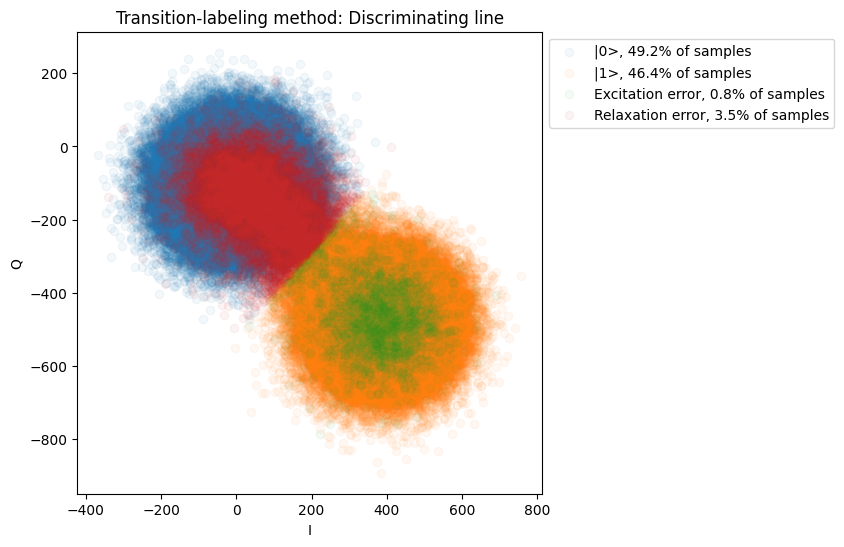

In [4]:
X_I_tmean, X_Q_tmean = thresholder.split_and_time_average(X)
fig, ax1 = plt.subplots(1, 1, figsize=(6,6))


idx0 = np.where(y_prime==0)[0]
idx1 = np.where(y_prime==1)[0]
idx2 = np.where(y_prime==2)[0]
idx3 = np.where(y_prime==3)[0]

ax1.scatter(X_I_tmean[idx0], X_Q_tmean[idx0], label = f"|0>, {(100*len(idx0)/X.shape[0]):.1f}% of samples", alpha=0.05)
ax1.scatter(X_I_tmean[idx1], X_Q_tmean[idx1], label = f"|1>, {(100*len(idx1)/X.shape[0]):.1f}% of samples", alpha=0.05)
ax1.scatter(X_I_tmean[idx2], X_Q_tmean[idx2], label = f"Excitation error, {(100*len(idx2)/X.shape[0]):.1f}% of samples", alpha=0.05)
ax1.scatter(X_I_tmean[idx3], X_Q_tmean[idx3], label = f"Relaxation error, {(100*len(idx3)/X.shape[0]):.1f}% of samples", alpha=0.05)
ax1.set_xlabel("I")
ax1.set_ylabel("Q")
ax1.legend(bbox_to_anchor = [1,1])
ax1.set_title("Transition-labeling method: Discriminating line")

## Fourier transform 

First, convert to complex numbers, then amplitude and phase

In [5]:
# Convert to complex
X_I = X[:, [i for i in range(X.shape[1]) if i%2==0]]
X_Q = X[:, [i for i in range(X.shape[1]) if i%2==1]]
X_complex = X_I + 1j*X_Q

# Fourier transform
X_fft = np.fft.fft(X_complex, axis=1)

# Order by increasing frequency 
X_fft_freqs = np.fft.fftfreq(X_complex.shape[1])/(3.25e-9)
freq_ordering = np.argsort(X_fft_freqs)
X_fft_freqs = X_fft_freqs[freq_ordering]
X_fft = X_fft[:, freq_ordering]

## Amplitude/phase vs. frequency, class differences

In [6]:
labels = [0, 1, 2, 3]
label_legends = {0: f"|0> = {(100*len(idx0)/X.shape[0]):.1f}% of samples", 
                 1: f"|1> = {(100*len(idx1)/X.shape[0]):.1f}% of samples", 
                2: f"Excitation-error = {(100*len(idx2)/X.shape[0]):.1f}% of samples",
                3: f"Relaxation-error= {(100*len(idx3)/X.shape[0]):.1f}% of samples"}

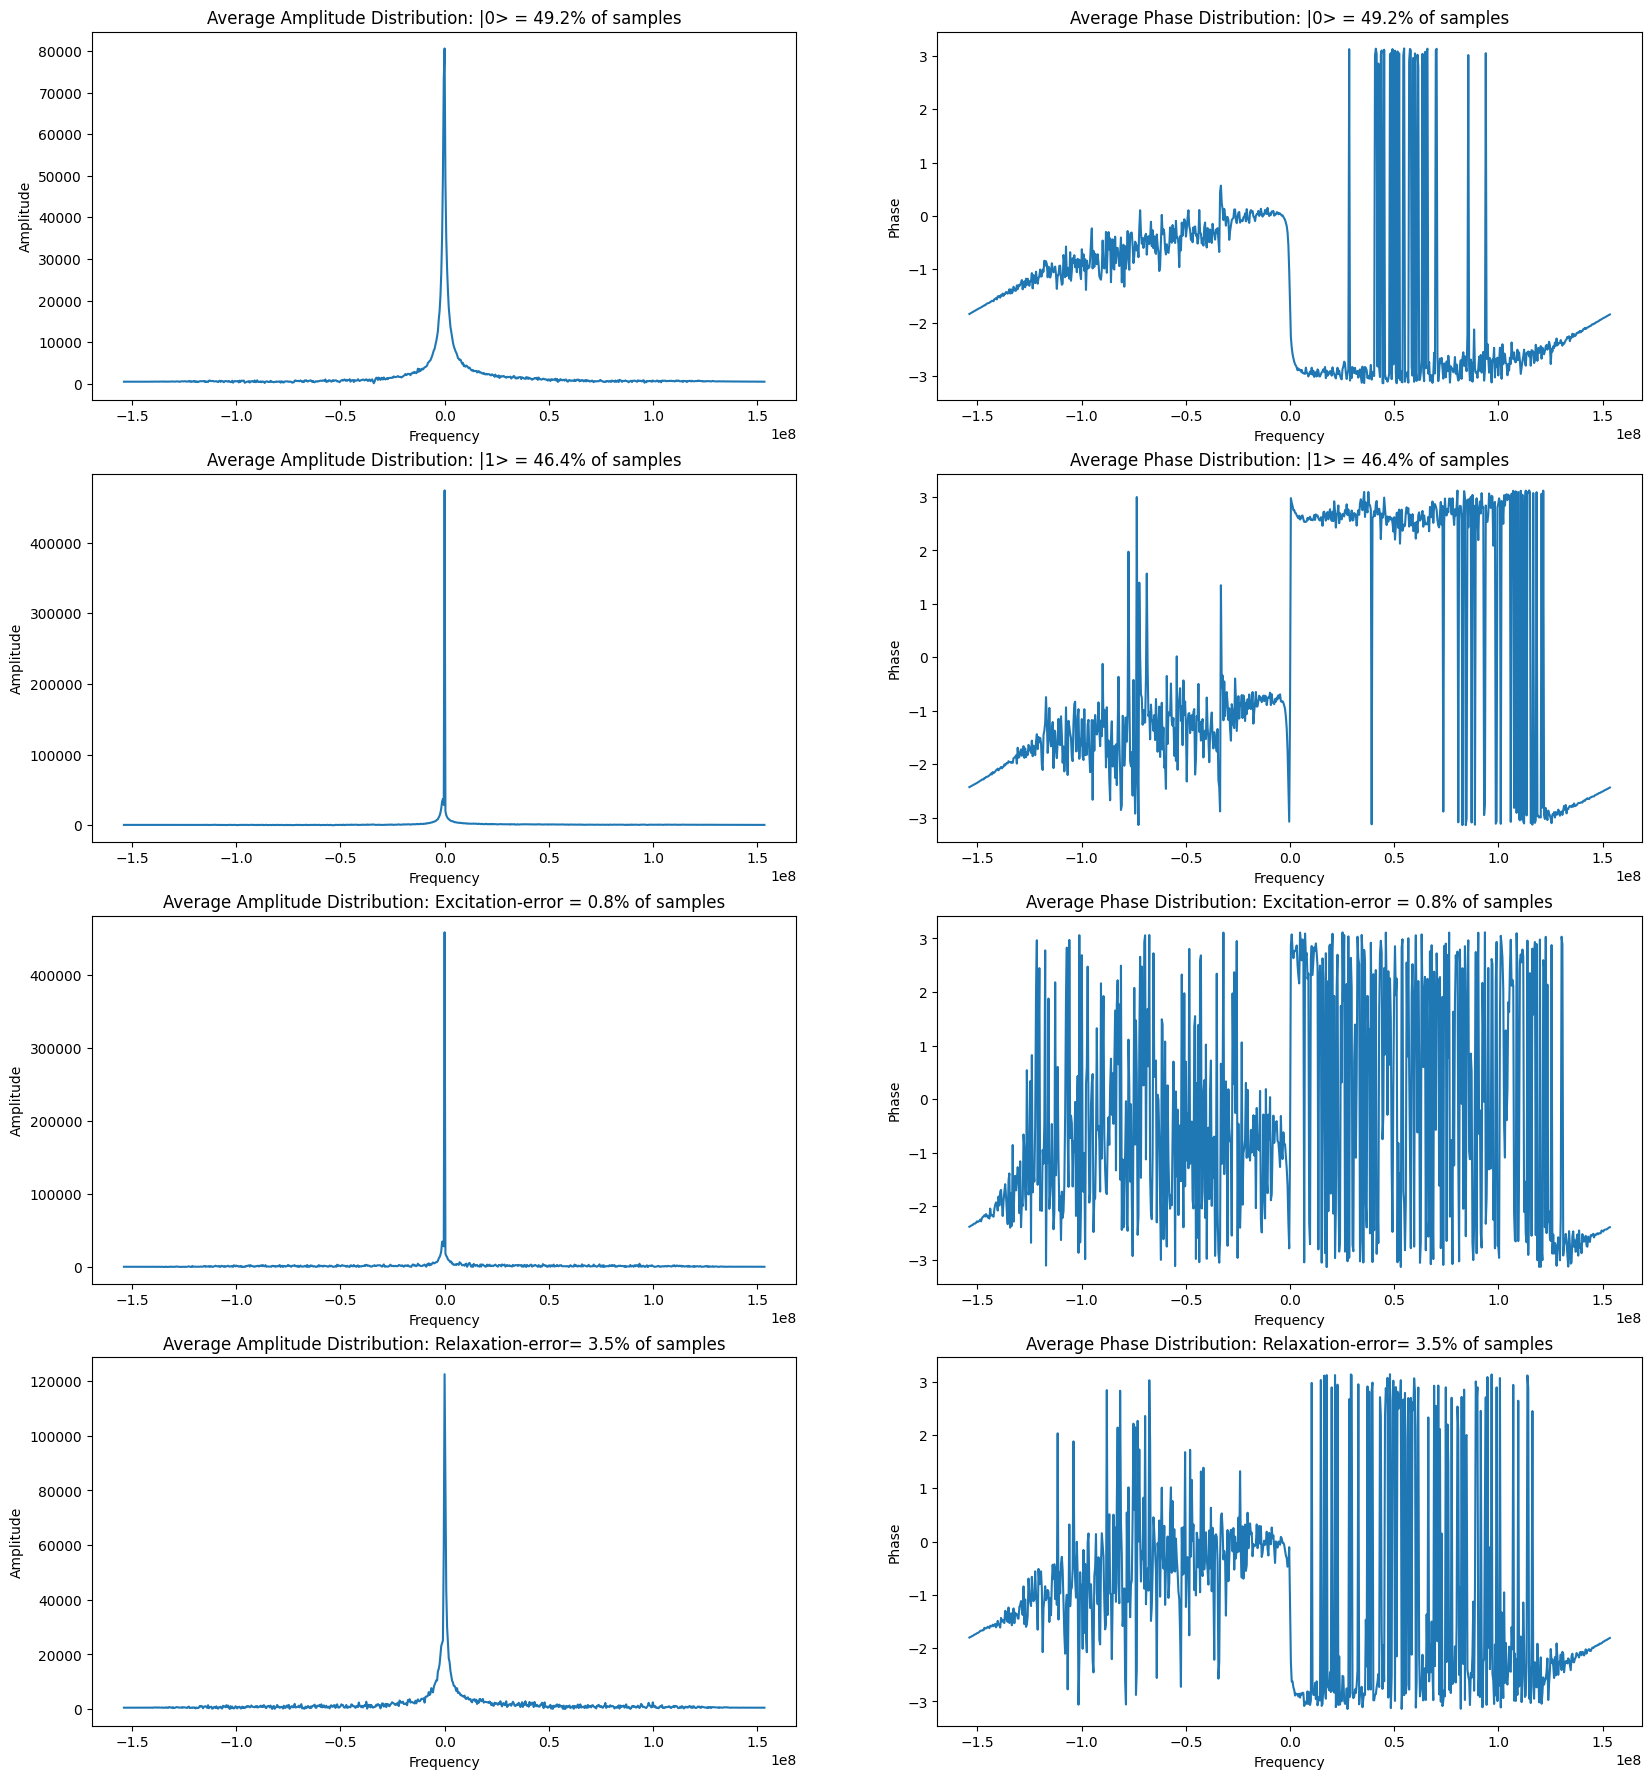

In [7]:
fig, axes = plt.subplots(4, 2, figsize = (20, 22))

for label in labels:
    label_idx = np.where(y_prime==label)[0]
    label_legend = label_legends[label]
    X_fft_label_mean = np.mean(X_fft[label_idx], axis=0)
    
    X_amp_label_mean = np.abs(X_fft_label_mean)
    axes[label, 0].plot(X_fft_freqs, X_amp_label_mean, label = label_legend)
    axes[label, 0].set_xlabel("Frequency")
    axes[label, 0].set_ylabel("Amplitude")
    axes[label, 0].set_title(f"Average Amplitude Distribution: {label_legends[label]}")

    X_phase_label_mean = np.angle(X_fft_label_mean)
    axes[label, 1].plot(X_fft_freqs, X_phase_label_mean, label = label_legend)
    axes[label, 1].set_xlabel("Frequency")
    axes[label, 1].set_ylabel("Phase")
    axes[label, 1].set_title(f"Average Phase Distribution: {label_legends[label]}")
    

Text(0.5, 0.98, 'Real qubit data, n_samples = 272700')

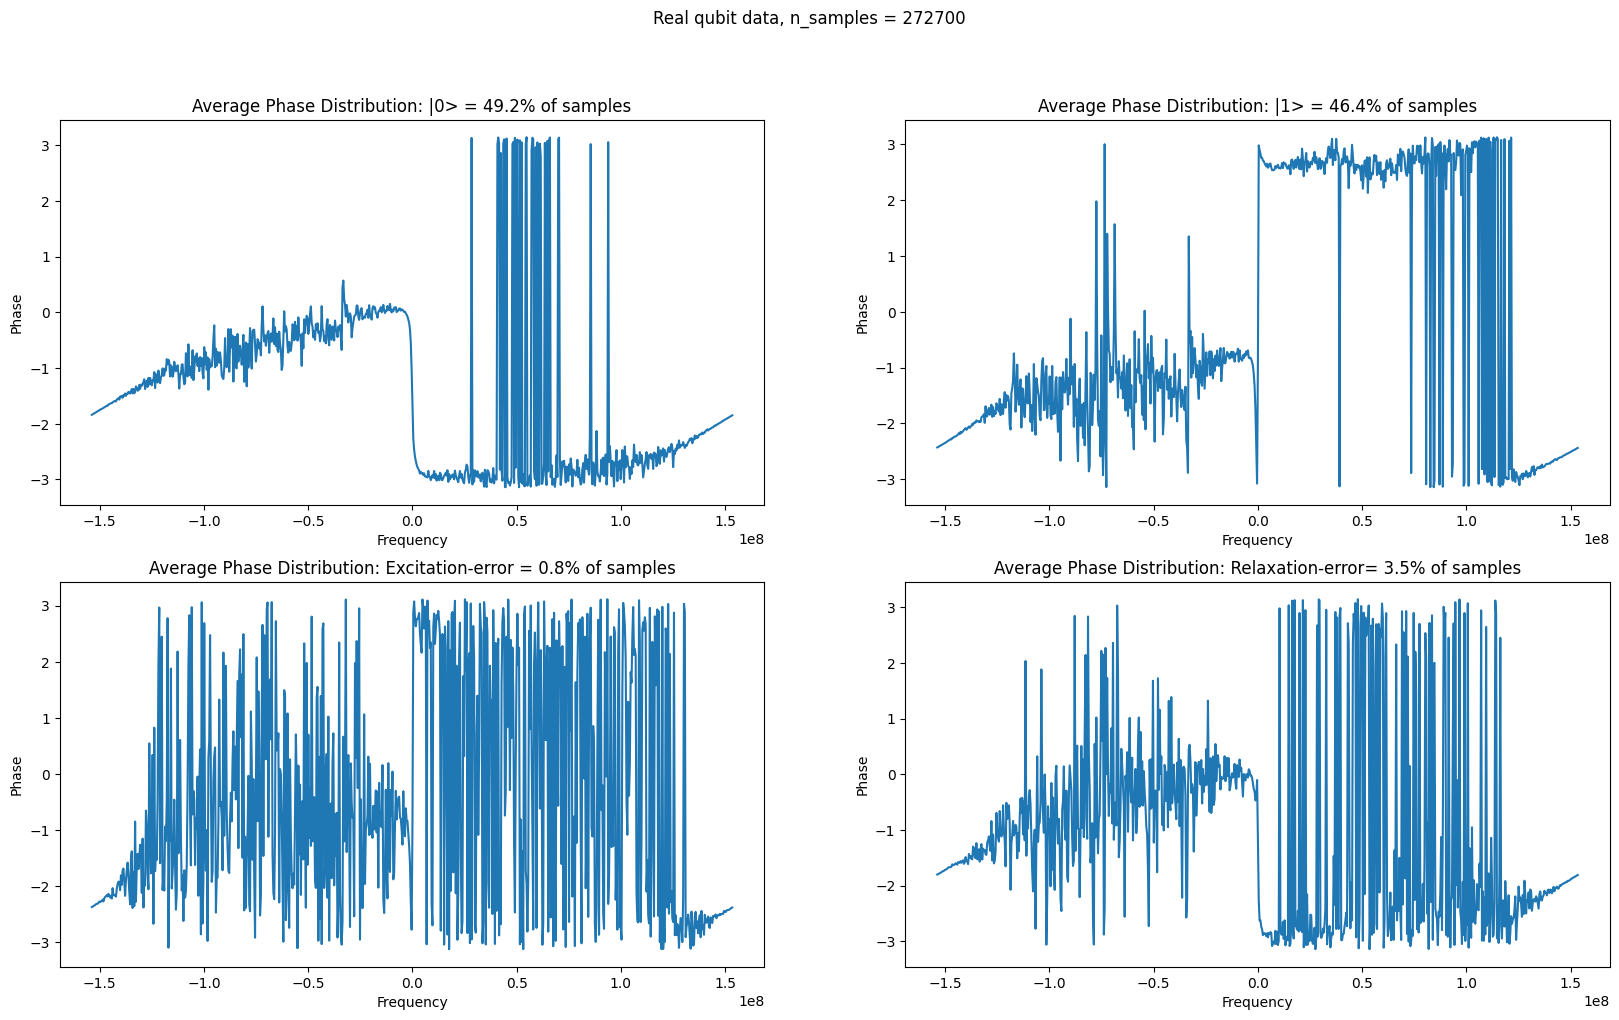

In [13]:
labels = [0, 1, 2, 3]
label_legends = {0: f"|0> = {(100*len(idx0)/X.shape[0]):.1f}% of samples", 
                 1: f"|1> = {(100*len(idx1)/X.shape[0]):.1f}% of samples", 
                2: f"Excitation-error = {(100*len(idx2)/X.shape[0]):.1f}% of samples",
                3: f"Relaxation-error= {(100*len(idx3)/X.shape[0]):.1f}% of samples"}
label_locs = [(0,0), (0,1), (1,0), (1,1)]

fig, axes = plt.subplots(2, 2, figsize = (20, 11))
for label in labels:
    
    label_idx = np.where(y_prime==label)[0]
    label_legend = label_legends[label]
    X_fft_label_mean = np.mean(X_fft[label_idx], axis=0)

    X_phase_label_mean = np.angle(X_fft_label_mean)
    axes[label_locs[label]].plot(X_fft_freqs, X_phase_label_mean, label = label_legend)
    axes[label_locs[label]].set_xlabel("Frequency")
    axes[label_locs[label]].set_ylabel("Phase")
    axes[label_locs[label]].set_title(f"Average Phase Distribution: {label_legends[label]}")

fig.suptitle(f"Real qubit data, n_samples = {X_fft.shape[0]}")

## Same thing, but zoomed in near 1MHz

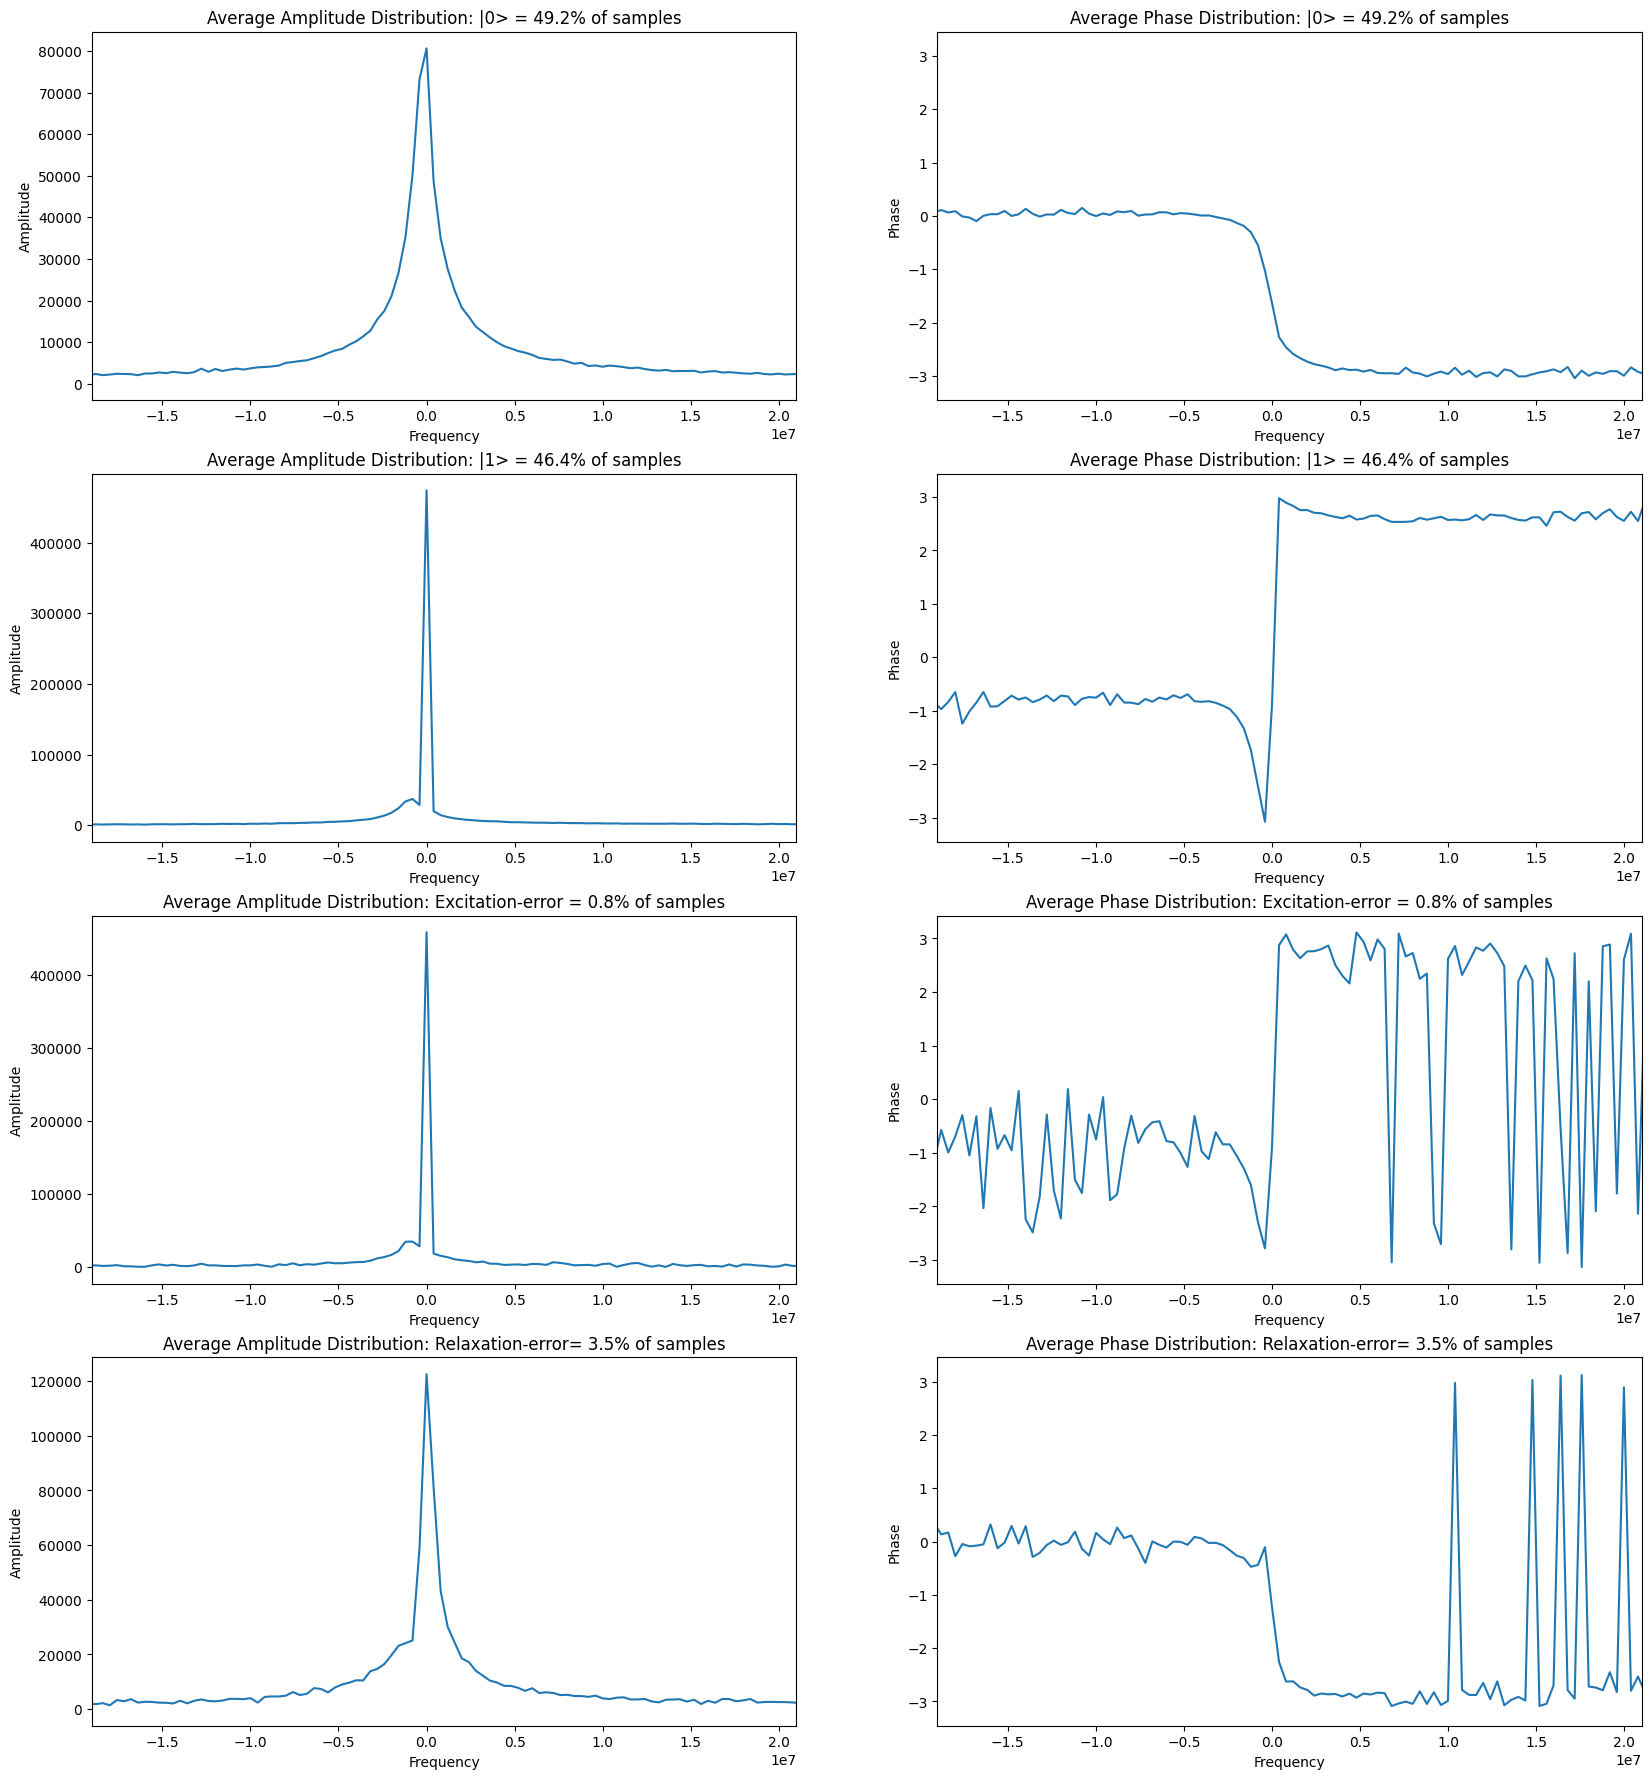

In [8]:
center = 1e6
ran = 2e7
xlims = (center - ran, center + ran)
fig, axes = plt.subplots(4, 2, figsize = (20, 22))

for label in labels:
    label_idx = np.where(y_prime==label)[0]
    label_legend = label_legends[label]
    #X_fft_label_mean = X_fft[label_idx][100]
    X_fft_label_mean = np.mean(X_fft[label_idx], axis=0)
    
    X_amp_label_mean = np.abs(X_fft_label_mean)
    axes[label, 0].plot(X_fft_freqs, X_amp_label_mean, label = label_legend)
    axes[label, 0].set_xlim(xlims)
    axes[label, 0].set_xlabel("Frequency")
    axes[label, 0].set_ylabel("Amplitude")
    axes[label, 0].set_title(f"Average Amplitude Distribution: {label_legends[label]}")

    X_phase_label_mean = np.angle(X_fft_label_mean)
    axes[label, 1].plot(X_fft_freqs, X_phase_label_mean, label = label_legend)
    axes[label, 1].set_xlim(xlims)
    axes[label, 1].set_xlabel("Frequency")
    axes[label, 1].set_ylabel("Phase")
    axes[label, 1].set_title(f"Average Phase Distribution: {label_legends[label]}")
    

## Find exact transition frequency

In [9]:
def find_transition_idx(X, diff_window_size = 1, smooth_window_size = 1): 
    # X.shape = (SAMPLE_LENGTH,)
    # Assumes SAMPLE_LENGTH >> window_size
    
    X_window_diff = np.zeros(X.shape)
    for i in range(diff_window_size, X.shape[0]):
        window_diff_i = np.abs(X[i] - X[i - diff_window_size])
        X_window_diff[i] = window_diff_i
        
    X_window_diff = X_window_diff[diff_window_size:]

    # Smooth
    X_window_diff_smoothed = np.zeros(X_window_diff.shape)
    for i in range(smooth_window_size, X_window_diff.shape[0]):
        window_mean_i = np.mean(X_window_diff[i-smooth_window_size:i])
        X_window_diff_smoothed[i] = window_mean_i
        
    X_window_diff_smoothed = X_window_diff_smoothed[smooth_window_size:]

    # Find (approximate) max index
    max_diff_idx = np.where(X_window_diff_smoothed == max(X_window_diff_smoothed))[0]
    return max_diff_idx+diff_window_size+smooth_window_size

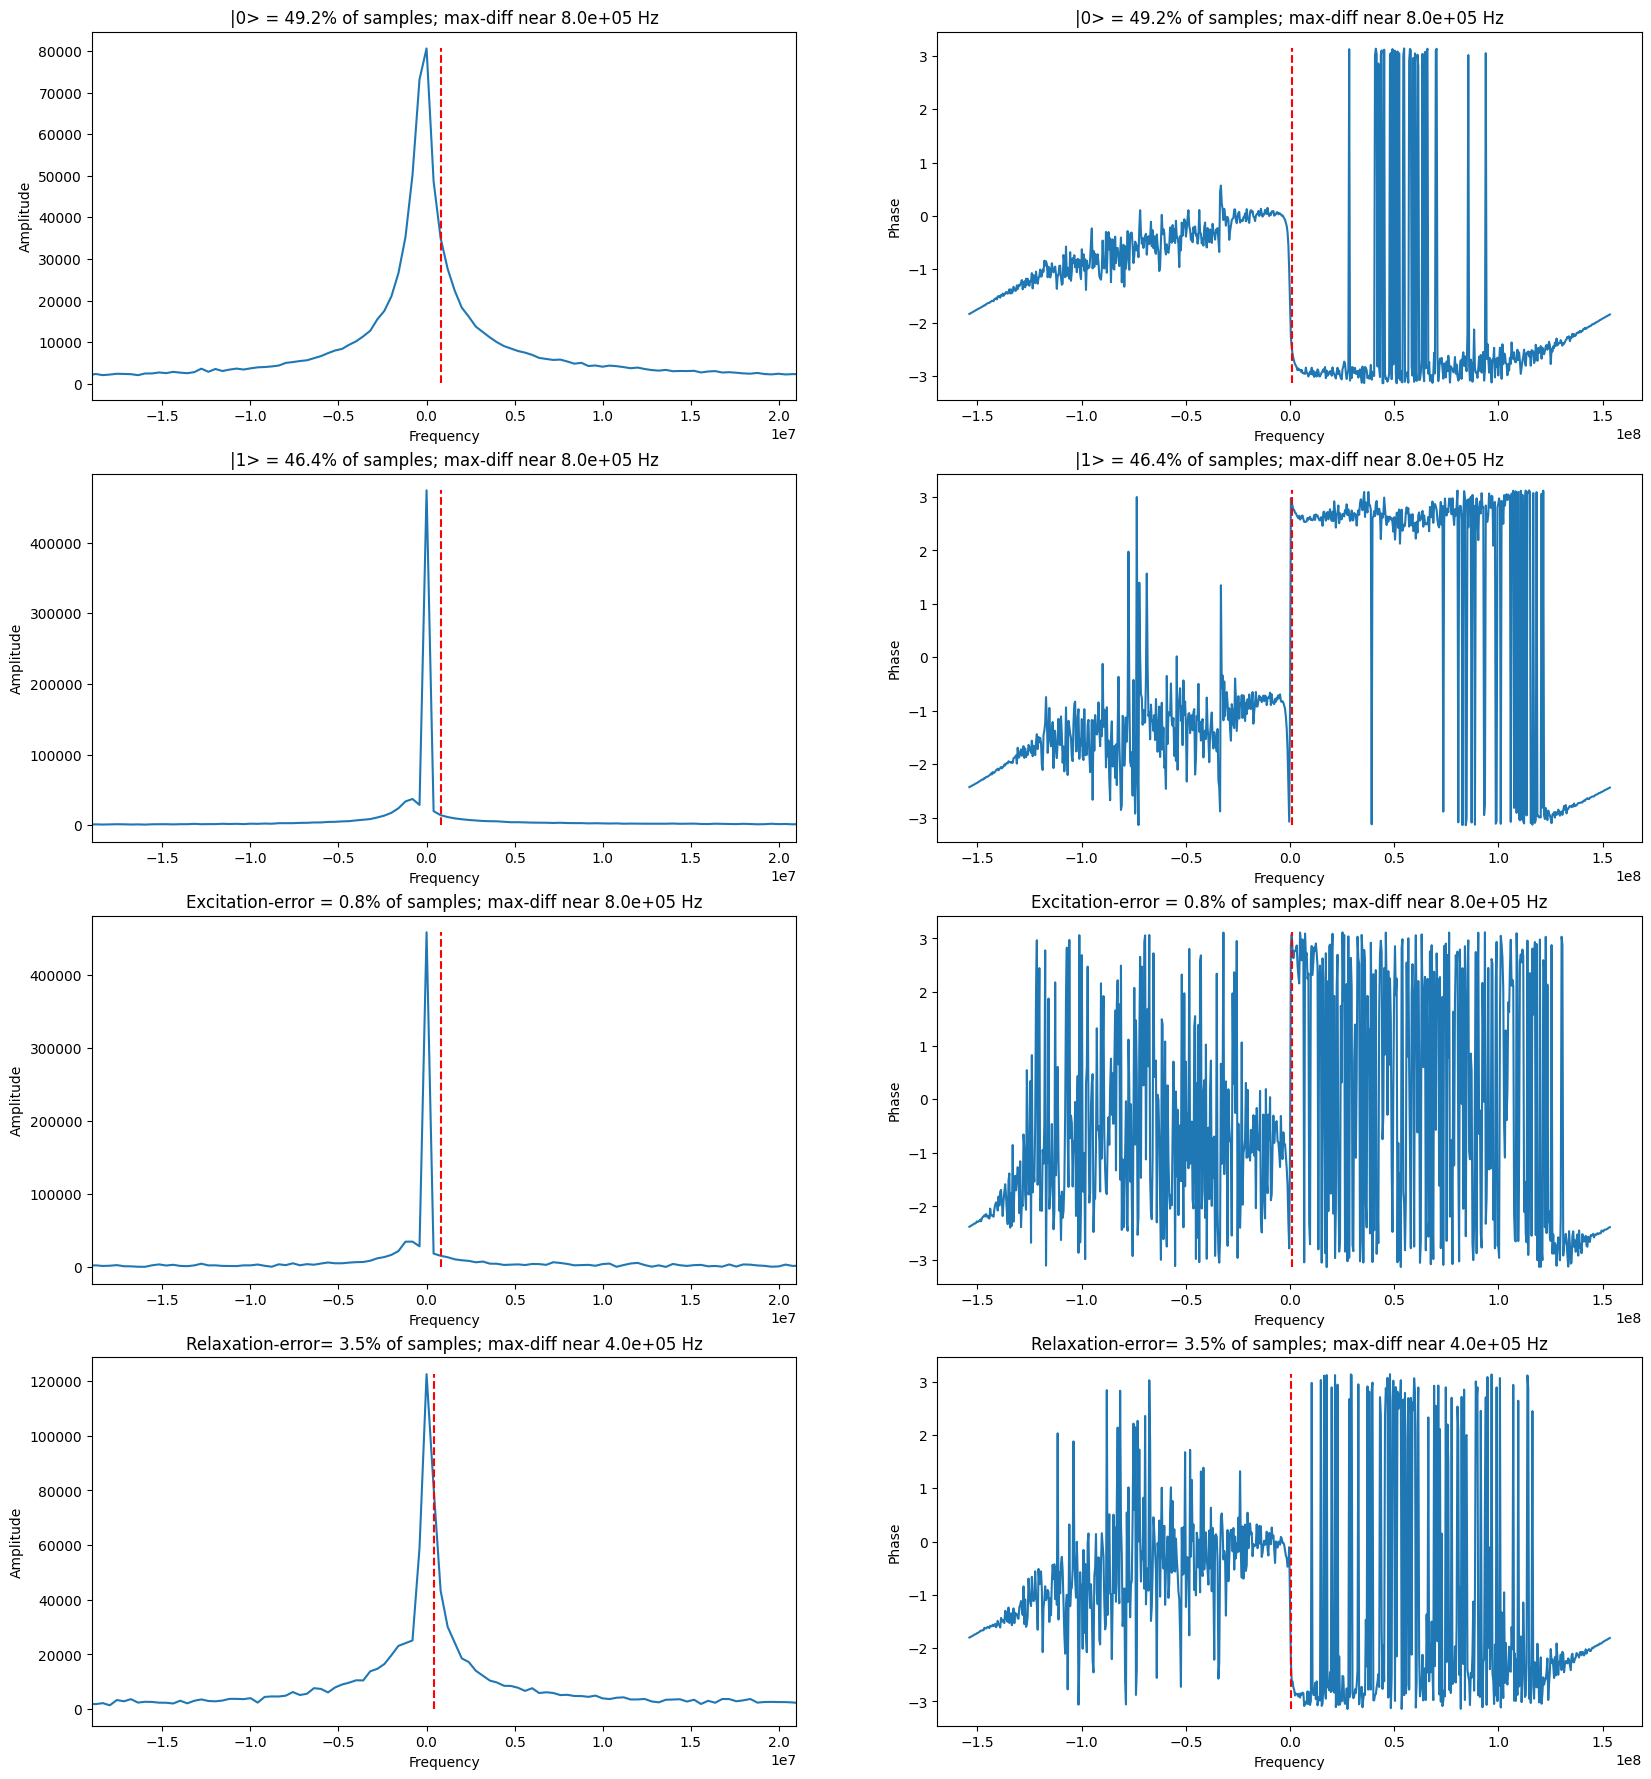

In [10]:
fig, axes = plt.subplots(4, 2, figsize = (20, 22))

for label in labels:
    label_idx = np.where(y_prime==label)[0]
    label_legend = label_legends[label]
    X_fft_label_mean = np.mean(X_fft[label_idx], axis=0)
    
    X_amp_label_mean = np.abs(X_fft_label_mean)
    X_amp_label_mean_max_diff_idx = find_transition_idx(X_amp_label_mean)
    X_amp_label_mean_max_diff_freq = X_fft_freqs[X_amp_label_mean_max_diff_idx]
    axes[label, 0].plot(X_fft_freqs, X_amp_label_mean, label = label_legend)
    axes[label, 0].plot(X_amp_label_mean_max_diff_freq[0]*np.ones(1000), np.linspace(min(X_amp_label_mean), max(X_amp_label_mean), 1000), 'r--')
    axes[label, 0].set_xlim(xlims)
    axes[label, 0].set_xlabel("Frequency")
    axes[label, 0].set_ylabel("Amplitude")
    axes[label, 0].set_title(f"{label_legends[label]}; max-diff near {X_amp_label_mean_max_diff_freq[0]:.1e} Hz")

    X_phase_label_mean = np.angle(X_fft_label_mean)
    X_phase_label_mean_max_diff_idx = find_transition_idx(X_phase_label_mean)
    X_phase_label_mean_max_diff_freq = X_fft_freqs[X_phase_label_mean_max_diff_idx]
    axes[label, 1].plot(X_fft_freqs, X_phase_label_mean, label = label_legend)
    axes[label, 1].plot(X_amp_label_mean_max_diff_freq[0]*np.ones(1000), np.linspace(min(X_phase_label_mean), max(X_phase_label_mean), 1000), 'r--')
    #axes[label, 1].set_xlim(xlims)
    axes[label, 1].set_xlabel("Frequency")
    axes[label, 1].set_ylabel("Phase")
    axes[label, 1].set_title(f"{label_legends[label]}; max-diff near {X_amp_label_mean_max_diff_freq[0]:.1e} Hz")
    


In [39]:
X_fft_0 =  X_fft[idx0]
X_fft_1 = X_fft[idx1]

In [40]:
X_a_0 = np.abs(X_fft_0)
X_p_0 = np.angle(X_fft_0)

X_a_1 = np.abs(X_fft_1)
X_p_1 = np.angle(X_fft_1)

X_f = np.fft.fftfreq(770, d=1/307.69e6)
X_0_min = X_p_0[:,2]

In [41]:
X_f[2]

799194.8051948053

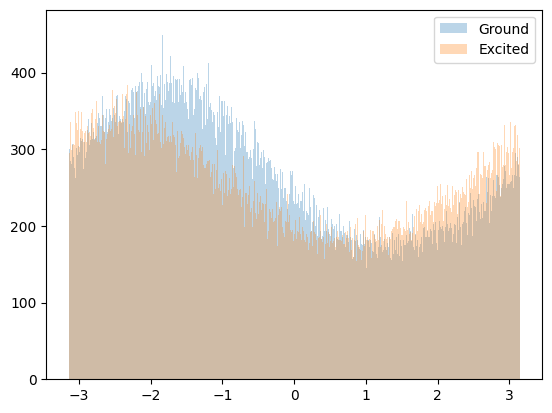

In [44]:
plt.figure()

plt.hist(X_p_0[:,2], label="Ground", alpha=0.3, bins=500)
plt.hist(X_p_1[:,2], label="Excited", alpha=0.3, bins=500)
plt.legend()

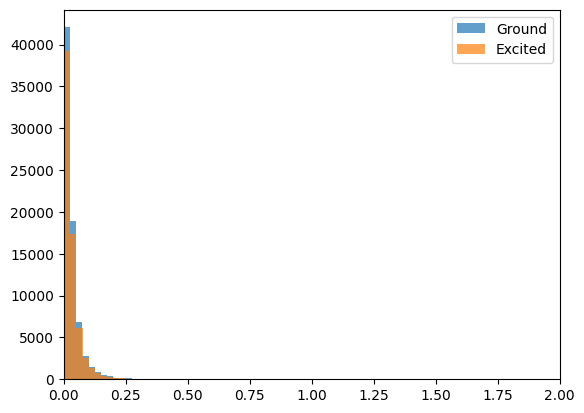

In [50]:
plt.figure()

plt.hist(X_p_0[:,2] - X_p_0[:,1], label="Ground", alpha=0.7, bins=500)
plt.hist(X_p_1[:,2] - X_p_1[:,1], label="Excited", alpha=0.7, bins=500)
plt.xlim((0,2))
plt.legend()

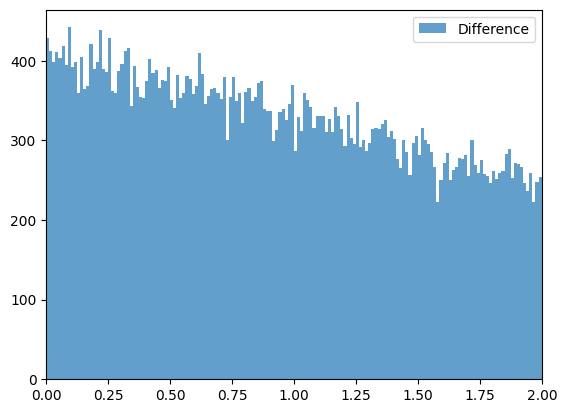

In [52]:
plt.figure()

plt.hist(np.abs(X_p_0[:int(1e5),2] - X_p_1[:int(1e5),2]), label="Difference", alpha=0.7, bins=500)
#plt.hist(X_p_1[:,2] - X_p_1[:,1], label="Excited", alpha=0.7, bins=500)
plt.xlim((0,2))
plt.legend()